# Gradient Descent Implementation Challenge!!

## Use gradient descent to find the optimal parameters of a **multiple** regression model. (We only showed an implementation for a bivariate model during lecture.)

A note: Implementing gradient descent in any context is not trivial, particularly the step where we calculate the gradient will change based on the number of parameters that we're trying to optimize for. You will need to research what the gradient of a multiple regression model looks like. This challenge is pretty open-ended but I hope it will be thrilling. Please work together, help each other, share resources and generally expand your understanding of gradient descent as you try and achieve this implementation. 

## Suggestions:

Start off with a model that has just two $X$ variables You can use any datasets that have at least two x variables. Potential candidates might be the blood pressure dataset that we used during lecture on Monday: [HERE](https://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/mlr/excel/mlr02.xls) or any of the housing datasets. You would just need to select from them the two varaibles $x$ variables and one y variable that you want to work with that you most want to work with. 

Use Sklearn to find the optimal parameters of your model first. (like we did during the lecture.) So that you can compare the parameter estimates of your gradient-descent linear regression to the estimates of OLS linear regression. If implemented correctly they should be nearly identical.

Becoming a Data Scientist is all about striking out into the unknown, getting stuck and then researching and fighting and learning until you get yourself unstuck. Work together! And fight to take your own learning-rate fueled step towards your own optimal understanding of gradient descent! 


In [1]:
# Incantations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
np.random.seed(42)

In [9]:
# Importing Monday's blood pressure dataset.
df = pd.read_excel('https://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/mlr/excel/mlr02.xls')
df = df.rename(index=str, columns={"X1": "y", "X2": "age", "X3": "weight"})
print(df.shape)
df.head()
y = df['y'].values.reshape(-1,1)
X = df[['age','weight']].values

*** No CODEPAGE record, no encoding_override: will use 'ascii'
(11, 3)


# Gradient descent

The gradient descent formula is given by:
![Gradient Descent formula](http://www.ryanleeallred.com/wp-content/uploads/2019/01/gradient-descent-formula.png)
Where each new theta_j results from subtracting a term composed of alpha and the slope of J evaluated at the current theta_j. Theta is the vector of coefficients that go into the linear regression. Theta = [beta_0, beta_i[0], ... beta_i[total dimensions - 1]].

The slope is something we'll determine soon, but is based on the error evaluated at theta_j

## Implemented part-by-part
I'll do this by parts first, to make sure that I understand what's going on before putting everything into a singel function.

In [3]:
# theta_null is the starting point for the equation, in this case chosen 
# because it's close to the global maximum given by OLS. 
theta_null = np.array([60, 5, 5]).reshape(3,-1)
print(f'theta_null: \n{theta_null}')
print(f'theta_null shape: \n{theta_null.shape}')

theta_null: 
[[60]
 [ 5]
 [ 5]]
theta_null shape: 
(3, 1)


In [4]:
# I first normalize X

# StandardScaler subtracts mean, normalizes to stdev=1
scaler = StandardScaler() 
# I apply the normalization to X. I changed the type to prevent a 
# dtype change warning from StandardScaler
X_norm = scaler.fit_transform(X.astype('float64'))
print(f'X_norm: \n{X_norm}')

X_norm: 
[[-1.20301838 -1.33261043]
 [-0.39751912 -0.66630522]
 [ 0.52305147 -0.0605732 ]
 [ 1.21347941  0.96917122]
 [ 0.1778375   0.0605732 ]
 [ 1.32855074  1.51433004]
 [-0.97287574 -0.42401241]
 [-0.16737647 -0.42401241]
 [ 0.29290882  0.72687842]
 [-1.89344632 -1.69604964]
 [ 1.09840809  1.33261043]]


In [5]:
# I then add a column of 1s at the beginning, destined to later be 
# multiplied by beta_0. I use the class parameter 'np.c_', which
# concatenates two arrays along the second axis (columns) and creates such
# an axis if it doesn't exist (as happens here with the np.ones 
# vector that has the same length as the rows in X_norm)
X_linalg = np.c_[np.ones(X_norm.shape[0]), X_norm]
print(f'X_linalg: \n{X_linalg}')

X_linalg: 
[[ 1.         -1.20301838 -1.33261043]
 [ 1.         -0.39751912 -0.66630522]
 [ 1.          0.52305147 -0.0605732 ]
 [ 1.          1.21347941  0.96917122]
 [ 1.          0.1778375   0.0605732 ]
 [ 1.          1.32855074  1.51433004]
 [ 1.         -0.97287574 -0.42401241]
 [ 1.         -0.16737647 -0.42401241]
 [ 1.          0.29290882  0.72687842]
 [ 1.         -1.89344632 -1.69604964]
 [ 1.          1.09840809  1.33261043]]


In [6]:
# I then make an array of predictions, y_hat, which for any 
# datapoint (row) in X_linalg is the result of multiplying all the terms
# by the regression equation coefficients in theta and adding up
# these products.  That is, the regression equation is evaluated at each
# row in X, which may contain multiple dimensions. The simple way to 
# calculate that is with the dot product. I'll include these calculations
# in a general function later, but for now I'll use the initialization
# values.
theta = theta_null
y_hat = np.dot(X_linalg, theta)
print(f'y_hat: \n{y_hat}')

y_hat: 
[[47.32185592]
 [54.68087833]
 [62.31239135]
 [70.91325318]
 [61.19205351]
 [74.21440387]
 [53.01555927]
 [57.04305559]
 [65.09893621]
 [42.05252017]
 [72.15509261]]


If we use 0.5* Mean Square Error as our cost function, as described [here](https://ml-cheatsheet.readthedocs.io/en/latest/linear_regression.html#id3), then the formula for the gradient at any given point is given by:

$gradient = (-X*(errors))/N$

where

$errors = targets-predictions = y - \hat{y}$ 

$N$ is the number of datapoints, and we're taking the dot product.

In [10]:
# The error comes from subtracting the actual y values from our 
# predictions, y_hat. Note that I had to reshape them so that the
# subtraction happened elementwise.
errors = y_hat - y
print(f'errors: \n{errors}')

errors: 
[[-84.67814408]
 [-88.31912167]
 [-90.68760865]
 [-91.08674682]
 [-92.80794649]
 [-93.78559613]
 [-83.98444073]
 [-91.95694441]
 [-93.90106379]
 [-85.94747983]
 [-93.84490739]]


In [11]:
gradient = np.dot(X_linalg.T, errors) / len(y)
# gradient = gradient.reshape(1,-1)
# print(f'gradient: \n{gradient}')
gradient

array([[-90.09090909],
       [ -2.98559946],
       [ -2.87998194]])

In [12]:
# And once we have the gradient, we update theta by subtracting the
# gradient times the learning rate alpha.
alpha = 0.1
theta = theta_null - alpha*gradient
theta

array([[69.00909091],
       [ 5.29855995],
       [ 5.28799819]])

# Putting it all together

In [13]:
def gradient_descent(X, y, theta_null, iterations, alpha):
    """
    Implements gradient descent
    
    X = array of variables
    y = array of results
    theta_null = initial guesses for the vector of coefficients, theta
    iterations = how many steps to take in the descent
    alpha = learning rate for each step
    """
    theta = theta_null
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X.astype('float64'))
    X_linalg = np.c_[np.ones(X_norm.shape[0]), X_norm]
    
    for _ in range(iterations):
        y_hat = np.dot(X_linalg, theta)
        errors = y_hat - y
        gradient = np.dot(X_linalg.T, errors) / len(y)
        theta = theta - alpha*gradient
    
    return theta, y_hat

In [14]:
X = df.loc[:, ['age','weight']].values
y = df.loc[:, ['y']].values
iterations = 2000
alpha = 0.01
theta_null = np.array([0, 0, 0]).reshape(3,-1)

In [15]:
theta_new, y_hat = gradient_descent(X, y, theta_null, iterations, alpha)

print(f'theta_new: \n{theta_new}')
print(f'\ny_hat: \n{y_hat}')
print(f'\ny (for comparison): \n{y}')

theta_new: 
[[150.09090881]
 [  7.15325343]
 [  5.86084025]]

y_hat: 
[[133.6751733 ]
 [143.34219712]
 [153.47731388]
 [164.45134842]
 [151.71801432]
 [168.46964871]
 [140.64671167]
 [146.40850741]
 [156.44635607]
 [126.60636683]
 [165.75835915]]

y (for comparison): 
[[132]
 [143]
 [153]
 [162]
 [154]
 [168]
 [137]
 [149]
 [159]
 [128]
 [166]]


# Visualization
To show that the program has converged to the right solution. Notice how close predicted (red) and observed (blue) points are in space.

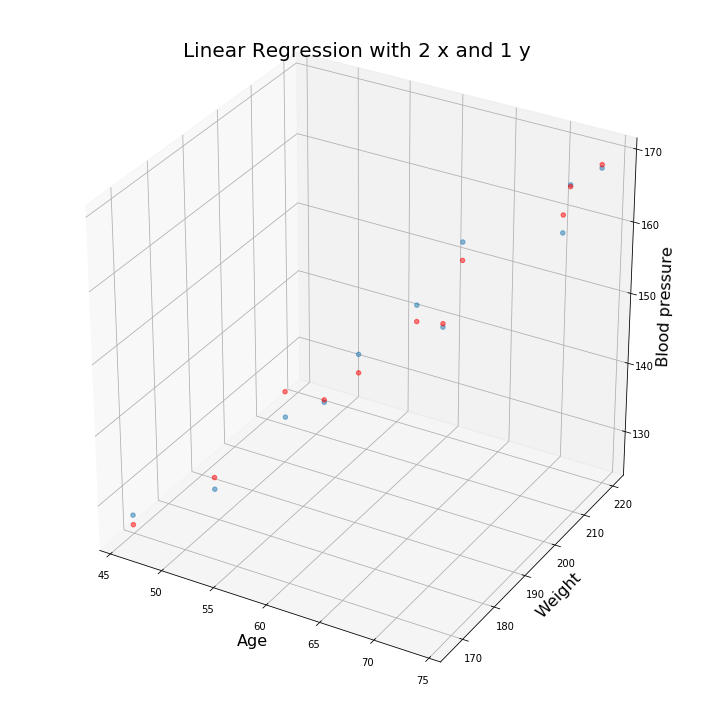

In [17]:
### Plotting
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot datapoints
ax.scatter(X[:,0], X[:,1], y, alpha=0.5);
ax.scatter(X[:,0], X[:,1], y_hat, alpha=0.5, color='r');

# Add labels
ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Weight', fontsize=16)
ax.set_zlabel('Blood pressure', fontsize=16)
ax.set_title('Linear Regression with 2 x and 1 y', fontsize=20);

plt.tight_layout()

# OLS Solution
This is the weirdest part.  For this dataset, the linear regression doesn't work and I have no idea why. The coefficients it suggests are totally off, and changed weirdly when I ran the code earlier. Part of my reason for showing the graph above is just to show that gradient descent did work, even if its results are very different from what the linear regression below shows.

In [19]:
y = df['y'].values
X = df[['age','weight']].values

model = LinearRegression()
model.fit(X, y)

# Assign coefficient and intercept to variables (beta_1, and beta_0)
beta_1 = model.coef_
beta_0 = model.intercept_

theta_OLS = np.array([beta_0, beta_1[0], beta_1[1]]).reshape(3,-1)
print(f"Theta from OLS: \n{theta_OLS}")

Theta from OLS: 
[[30.99410295]
 [ 0.86141469]
 [ 0.3348592 ]]


In [20]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X.astype('float64'))
X_linalg = np.c_[np.ones(X_norm.shape[0]), X_norm]
y_hat_OLS = np.dot(X_linalg, theta_OLS)
y_hat_OLS

array([[29.51156839],
       [30.42855572],
       [31.42438368],
       [32.36394784],
       [31.16757828],
       [32.64562341],
       [30.01406905],
       [30.70793795],
       [31.48982084],
       [28.79512266],
       [32.38652467]])

## Stretch Goals

If you happen upon the most useful resources for accomplishing this challenge first, I want you to spend time today studying other variations of Gradient Descent-Based Optimizers.

- Try and write a function that can perform gradient descent for arbitarily large (in dimensionality) multiple regression models. 
- Create a notebook for yourself exploring these topics
- How do they differ from the "vanilla" gradient descent we explored today
- How do these different gradient descent-based optimizers seek to overcome the challenge of finding the global minimum among various local minima?
- Write a blog post that reteaches what you have learned about these other gradient descent-based optimizers.

[Overview of GD-based optimizers](http://ruder.io/optimizing-gradient-descent/)

[Siraj Raval - Evolution of Gradient Descent-Based Optimizers](https://youtu.be/nhqo0u1a6fw)